# [1] Exploring GrandTour Data
© 2025 ETH Zurich

 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leggedrobotics/grand_tour_dataset/blob/main/examples/%5B1%5D_Exploring_GrandTour_Data.ipynb)

## Setup

> Note: This notebook uses the [ZARR](https://zarr.dev/) file format for maximum compatibility, but ROS users can apply the information here to ROSbag and MCAP data as the data fields are the same across all formats.

#### Runtime
Because of the file sizes involved, it is best to run this tutorial connected to a local runtime. You can run a Docker or Jupyter local runtime following the instructions [here](https://research.google.com/colaboratory/local-runtimes.html). The tutorial has been tested with the Jupyter runtime.


#### Data
This tutorial assumes you have the 2024-10-01-11-29-55 mission locally downloaded and extracted from its `.tar` files into ZARR format. See the first tutorial - _[0] Accessing GrandTour Data_ - if you don't yet have the data. Set your path below:

In [4]:
# Should be path to the dataset folder that holds the /data and /images folders
dataset_path = "/home/kappi/grand_tour_data/2024-10-01-11-29-55"

#### Dependencies

In [2]:
!pip install -q zarr matplotlib plotly rich opencv-python IPython scipy


## What's in a **Mission**?
A mission consists of a single continuous deployment of the robot. The sensor data from *Boxi* and from the ANYmal D base platform are available. These consist of:

* Position Data
* Cameras
* LiDARs

The full list of sensors on *Boxi* and the ANYmal D can be seen on the GrandTour webpage.

This tutorial will demonstrate how to access and intepret these three kinds of data. First, we load the mission with `zarr`:

In [5]:
import zarr
import zarr.storage

data_path = dataset_path + "/data"

store = zarr.storage.LocalStore(data_path)
root = zarr.group(store=store)
mission_root = zarr.open_group(data_path, mode='r')
# Take a look at the available data
print(mission_root.tree())

/
├── adis_imu
│   ├── ang_vel (69333, 3) float64
│   ├── ang_vel_cov (69333, 3, 3) float64
│   ├── lin_acc (69333, 3) float64
│   ├── lin_acc_cov (69333, 3, 3) float64
│   ├── orien (69333, 4) float64
│   ├── orien_cov (69333, 3, 3) float64
│   ├── sequence_id (69333,) uint64
│   └── timestamp (69333,) uint64
├── alphasense_cam1
│   ├── sequence_id (3588,) uint64
│   └── timestamp (3588,) uint64
├── alphasense_cam2
│   ├── sequence_id (3587,) uint64
│   └── timestamp (3587,) uint64
├── alphasense_cam3
│   ├── sequence_id (3588,) uint64
│   └── timestamp (3588,) uint64
├── alphasense_cam4
│   ├── sequence_id (3588,) uint64
│   └── timestamp (3588,) uint64
├── alphasense_cam5
│   ├── sequence_id (3588,) uint64
│   └── timestamp (3588,) uint64
├── ap20_imu
│   ├── ang_vel (68029, 3) float64
│   ├── ang_vel_cov (68029, 3, 3) float64
│   ├── lin_acc (68029, 3) float64
│   ├── lin_acc_cov (68029, 3, 3) float64
│   ├── orien (68029, 4) float64
│   ├── orien_cov (68029, 3, 3) float64
│   ├── 

### Position Data
When available (when the prism mounted on *Boxi* is visible to the Totalstation), the Leica Geosystem`s MS60 Totalstation provides sub-cm precision Ground Truth position data. Below we access and plot this data.

In [7]:
ground_truth = mission_root["prism"]["point"]
ground_truth_numpy = ground_truth[:]
print(ground_truth_numpy.shape)


(4738, 3)


In [8]:
#@title Plot Trajectory
import plotly.graph_objects as go
import numpy as np

# Extract X, Y, Z coordinates
x, y, z = ground_truth_numpy[:, 0], ground_truth_numpy[:, 1], ground_truth_numpy[:, 2]

# Create a 3D scatter plot with a trajectory line
fig = go.Figure()

# Add trajectory line
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode="lines",
    line=dict(color="blue", width=3),
    name="Trajectory"
))

# Add start & end points
fig.add_trace(go.Scatter3d(
    x=[x[0]], y=[y[0]], z=[z[0]],
    mode="markers",
    marker=dict(size=8, color="green"),
    name="Start"
))

fig.add_trace(go.Scatter3d(
    x=[x[-1]], y=[y[-1]], z=[z[-1]],
    mode="markers",
    marker=dict(size=8, color="red"),
    name="End"
))

# Compute axis limits to ensure equal scale
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
mid_x = (x.max() + x.min()) / 2.0
mid_y = (y.max() + y.min()) / 2.0
mid_z = (z.max() + z.min()) / 2.0

# Update layout with equal axis scaling
fig.update_layout(
    title="3D ANYmal D Trajectory (Z Axis Scale Enlarged)",
    scene=dict(
        xaxis=dict(range=[mid_x - max_range, mid_x + max_range]),
        yaxis=dict(range=[mid_y - max_range, mid_y + max_range]),
        zaxis=dict(range=[mid_z - max_range /10 , mid_z + max_range / 10]),
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


### Camera Data
*Boxi* has 10 cameras (Sevensense Core Research 5-Camera Development Kit, 3 Tier IV HDR cameras, Stereolabs Zed 2i), and the ANYmal platform has a front-facing depth camera. Here we look at the front facing Tier IV.

In [10]:
#@title Preview Tier IV Front Camera Data

import os
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Define image directory
image_dir = dataset_path + "/images"
tier4_front_dir = image_dir + "/hdr_front"

# Set the start index
start_idx = 200  # Change this to any starting index
num_frames = 50  # Number of frames to display

# Get sorted list of image files
image_files = sorted([f for f in os.listdir(tier4_front_dir) if f.endswith((".jpeg"))])

# Slice the list to get images from start_idx to start_idx + num_frames
selected_files = image_files[start_idx:start_idx + num_frames]

# Loop through selected images
for idx, filename in enumerate(selected_files, start=start_idx):
    img = cv2.imread(os.path.join(tier4_front_dir, filename))

    # Convert BGR to RGB for proper color display
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Clear previous output (for smooth playback)
    clear_output(wait=True)

    # Display new image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")  # Hide axis
    plt.title(f"Displaying Frame: {idx}")
    plt.show()

    # Wait before showing the next image
    cv2.waitKey(50)  # Adjust speed (50ms per frame)












Traceback (most recent call last):
  File "/home/kappi/.vscode/extensions/ms-python.python-2025.0.0-linux-x64/python_files/python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
  File "<string>", line 37, in <module>
  File "/home/kappi/miniconda3/envs/huggingface/lib/python3.13/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
           ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/home/kappi/miniconda3/envs/huggingface/lib/python3.13/site-packages/matplotlib/backend_bases.py", line 3547, in show
    cls.mainloop()
    ~~~~~~~~~~~~^^
  File "/home/kappi/miniconda3/envs/huggingface/lib/python3.13/site-packages/matplotlib/backends/_backend_tk.py", line 544, in start_main_loop
    first_manager.window.mainloop()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/home/kappi/miniconda3/envs/huggingface/lib/python3.13/tkinter/__init__.py", line 1599, in mainloop
    self.tk.mainloop(

### LiDAR Data

We provide undistorted point clouds as well as raw LiDAR data.

In [11]:
undistorded_lidar = mission_root["dlio"]["point_cloud_points"]
undistorded_lidar_numpy = undistorded_lidar[:]
undistorded_lidar_numpy = undistorded_lidar_numpy[0] # Use the first pointcloud in the mission.

In [13]:
#@title Undistorted LiDAR Point Cloud
x, y, z = undistorded_lidar_numpy[:, 0], undistorded_lidar_numpy[:, 1], undistorded_lidar_numpy[:, 2]

# Normalize z values for coloring
z_min, z_max = z.min(), z.max()
colorscale = (z - z_min) / (z_max - z_min)  # Normalize between 0 and 1

# Create 3D scatter plot for LiDAR point cloud
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode="markers",
    marker=dict(
        size=2,
        color=colorscale,  # Color based on height
        colorscale="Viridis",  # Use a perceptually uniform colormap
        opacity=0.8
    ),
    name="LiDAR Point Cloud"
))

# Compute axis limits for equal scaling
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
mid_x = (x.max() + x.min()) / 2.0
mid_y = (y.max() + y.min()) / 2.0
mid_z = (z.max() + z.min()) / 2.0

# Update layout with equal axis scaling
fig.update_layout(
    title="LiDAR Point Cloud Visualization",
    scene=dict(
        xaxis=dict(range=[mid_x - max_range, mid_x + max_range], title="X"),
        yaxis=dict(range=[mid_y - max_range, mid_y + max_range], title="Y"),
        zaxis=dict(range=[mid_z - max_range, mid_z + max_range], title="Z"),
        camera=dict(
            eye=dict(x=0.07, y=0.44, z=-0.02),  # Camera position
            center=dict(x=0, y=0, z=-0.1)  # Look at
        )
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

## Fusing Sensor Data
We provide camera intrinsic and extrinsic calibration data, as well as transforms between the frames of the various sensors.



### Frames Overview

![picture](https://raw.githubusercontent.com/leggedrobotics/grand_tour_dataset/refs/heads/main/assets/boxi-frames.png?token=GHSAT0AAAAAACX6Q2VDMJAQK5MNAOPVDH46Z5UP4FQ)

TODO: Add sensor frame names


### Calibration (Camera Intrinsic and Sensor Frame Transformation) Data

Calibration data can be found in `.yaml` format in the `/metadata` directory of the HuggingFace datasets, as well as in ROSbag format in TODO. The calibrations can vary by mission, so make sure you have the correct data for your purposes.

Enter the path to the local `.yaml` file.

In [14]:
import os
# Path to the calibration YAML file for the camera.
camera_calib_file_path = dataset_path + "/metadata/hdr_front.yaml"

We can define a function to extract homogenous transformation matrices from the `.yaml` data:

In [ ]:
def homogenous_transformation_matrix(calib_data):
    # Extract translation
    t = np.array([
        calib_data["transform"]["translation"]["x"],
        calib_data["transform"]["translation"]["y"],
        calib_data["transform"]["translation"]["z"]
    ])

    # Extract quaternion (given in [w, x, y, z] format)
    q = np.array([
        calib_data["transform"]["rotation"]["w"],
        calib_data["transform"]["rotation"]["x"],
        calib_data["transform"]["rotation"]["y"],
        calib_data["transform"]["rotation"]["z"]
    ])

    # Convert quaternion to rotation matrix.
    # Note: SciPy expects the quaternion in [x, y, z, w] order.
    rot = R.from_quat([q[1], q[2], q[3], q[0]])
    R_matrix = rot.as_matrix()

    # Construct the 4x4 homogeneous transformation matrix.
    T = np.eye(4)
    T[:3, :3] = R_matrix
    T[:3, 3] = t

    return T

We can inspect the available intrinsic camera calibration data in the file. Transformations from each sensor to the box base are also given, which we can look at below.

In [56]:
import os
import yaml
import numpy as np
import pprint
from scipy.spatial.transform import Rotation as R

# Load the calibration file
with open(camera_calib_file_path, 'r') as f:
    camera_calib_data = yaml.safe_load(f)

pprint.pprint(f"Available Data: {', '.join(camera_calib_data.keys())}")

K = np.array(camera_calib_data["camera_info"]["K"]).reshape(3, 3)
print("\nCamera Intrinsics (K):")
pprint.pprint(K)

D = np.array(camera_calib_data["camera_info"]["D"])
print("\nCamera Distortion Coefficients (D):")
pprint.pprint(D)

T_base_camera = homogenous_transformation_matrix(camera_calib_data)

print("\nHomogenous Transformation Matrix:")
print(T_base_camera)


'Available Data: camera_info, frame_id, topic, transform'

Camera Intrinsics (K):
array([[984.81087656,   0.        , 948.02998334],
       [  0.        , 984.55484998, 636.71078365],
       [  0.        ,   0.        ,   1.        ]])

Camera Distortion Coefficients (D):
array([-0.0594498 ,  0.00211175, -0.00142132,  0.00034274])

Homogenous Transformation Matrix:
[[-0.00709679 -0.00103354  0.99997428  0.44700019]
 [-0.99996541  0.00434395 -0.00709223  0.01009004]
 [-0.00433651 -0.99999003 -0.00106434  0.17775094]
 [ 0.          0.          0.          1.        ]]


In order to fuse LiDAR with the hdr_front camera, we will also need the LiDAR's transformation from the base frame:

In [ ]:
lidar_calib_file_path = dataset_path + "/metadata/dlio.yaml"

with open(lidar_calib_file_path, 'r') as f:
    lidar_calib_data = yaml.safe_load(f)

T_base_lidar = homogenous_transformation_matrix(lidar_calib_data)

print("\nHomogenous Transformation Matrix:")
print(T_base_lidar)


Homogenous Transformation Matrix:
[[ 0.00671602 -0.99997413  0.00257519  0.38134564]
 [ 0.99992014  0.00668805 -0.01072262  0.00595562]
 [ 0.01070511  0.002647    0.9999392   0.29405521]
 [ 0.          0.          0.          1.        ]]


### Camera + LiDAR Fusion Example

Now that we have camera, LiDAR and calibration data, we can fuse them and display the pointcloud on the imagery.

#### Helper Functions

In [25]:
#@title Helper Functions
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_pcd_on_image(image, xyz_points, K, D, transform=None):
    """
    Overlays 3D LiDAR points (colored by depth) onto a camera image.

    Parameters:
    - image (np.ndarray): The camera image (assumed to be in RGB format).
    - xyz_points (np.ndarray): LiDAR points (N, 3) in the LiDAR frame.
    - K (np.ndarray): Camera intrinsic matrix (3x3).
    - D (np.ndarray): Distortion coefficients (e.g., for fisheye).
    - transform (np.ndarray, optional): 4x4 transformation matrix to convert 
                                        LiDAR points to camera frame. Defaults to None.

    Returns:
    - output_image (np.ndarray): The image with overlaid LiDAR points.
    """
    # If a transformation is provided, convert points to the camera frame.
    if transform is not None:
        ones = np.ones((xyz_points.shape[0], 1))
        xyz_hom = np.hstack((xyz_points, ones))
        xyz_transformed = (transform @ xyz_hom.T).T[:, :3]
    else:
        xyz_transformed = xyz_points

    # Only keep points in front of the camera (positive z).
    xyz_transformed = xyz_transformed[xyz_transformed[:, 2] > 0]
    
    # Project 3D points to 2D using the fisheye model.
    projected_points, _ = cv2.fisheye.projectPoints(
        xyz_transformed[:, None, :],  # reshape to (N,1,3)
        np.zeros(3),  # zero rotation vector
        np.zeros(3),  # zero translation vector
        K,
        D
    )
    projected_points = projected_points.squeeze(axis=1)  # reshape to (N,2)

    # Map depth to color: we'll use the z-value for colorization.
    depths = xyz_transformed[:, 2]
    normalized_depths = (depths - depths.min()) / (depths.max() - depths.min() + 1e-6)
    # Enhance contrast by taking a square root (optional)
    normalized_depths = np.sqrt(normalized_depths)
    colors = cv2.applyColorMap((normalized_depths * 255).astype(np.uint8), cv2.COLORMAP_TURBO)

    # Create a copy of the image to overlay points.
    output_image = image.copy()

    # Overlay each projected point onto the image.
    for pt, color in zip(projected_points, colors):
        x, y = int(round(pt[0])), int(round(pt[1]))
        # Check if point falls within image bounds.
        if 0 <= x < output_image.shape[1] and 0 <= y < output_image.shape[0]:
            cv2.circle(output_image, (x, y), radius=2, color=tuple(int(c) for c in color.flatten().tolist()), thickness=-1)
    
    return output_image




#### Final Composite

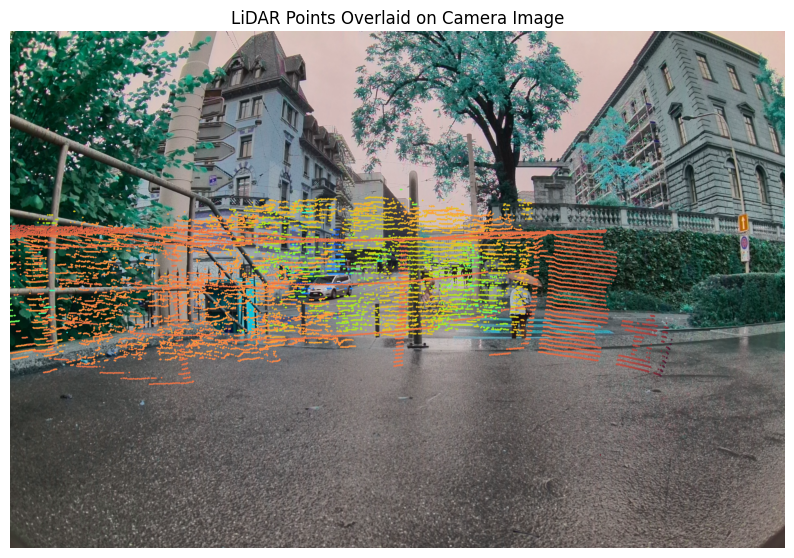

In [45]:
# Here:
# - 'img' is the camera image loaded as a NumPy array in RGB format.
# - 'lidar_points' is the LiDAR point cloud as an (N, 3) NumPy array.
# - 'K' and 'D' are the camera's intrinsic matrix and distortion coefficients.
# - 'T_lidar_to_camera' is a 4x4 transformation from the LiDAR frame to the camera frame.

# Compute the inverse of T_base_camera to get T_camera_base
T_camera_base = np.linalg.inv(T_base_camera)

# Combine to get the transformation from LiDAR to Camera frame
T_camera_lidar = T_camera_base @ T_base_lidar

# Use the lidar poiints from the earlier example
lidar_points = undistorded_lidar_numpy
# Use the front HDR image from the earlier example
img = cv2.imread(os.path.join(tier4_front_dir, image_files[0]))

# # Overlay the LiDAR points on the image.
overlay_image = overlay_pcd_on_image(img, lidar_points, K, D, transform=T_camera_lidar)

# # Display the result using Matplotlib.
plt.figure(figsize=(10, 8))
plt.imshow(overlay_image)
plt.axis("off")
plt.title("LiDAR Points Overlaid on Camera Image")
plt.show()